In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC

import cv2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from itertools import count
iid = count()

SEED = 42    # random state seed for consistent results

### 0. Preprocessing

In [2]:
%%time
train_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
train_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")

CPU times: user 1min 50s, sys: 1min 2s, total: 2min 53s
Wall time: 6min 16s


#### Reshape to easily visualize while cleaning data

In [3]:
%%time
x = train_X.reshape(-1, 64, 64)

imgs = []
for idx in range(len(x)):
    img_id = next(iid)
    cv2.imwrite('Output/{}.jpg'.format(img_id), 255-x[idx])
    imgs.append(cv2.imread('Output/{}.jpg'.format(img_id), 0))

CPU times: user 6.88 s, sys: 4.47 s, total: 11.4 s
Wall time: 14.6 s


We will first transform to binary image (black, white):

In [4]:
%%time
bin_imgs = []
for img in imgs:
    _, bin_img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    bin_imgs.append(bin_img)

CPU times: user 133 ms, sys: 69.5 ms, total: 203 ms
Wall time: 222 ms


Then we will remove the noice by dilatating and eroding the image:

In [5]:
%%time
denoised_imgs = []
for bin_img in bin_imgs:
    dilatated = cv2.dilate(bin_img, np.ones((3,3)))
    denoised_imgs.append(cv2.erode(dilatated, np.ones((3,3))))

CPU times: user 1.41 s, sys: 103 ms, total: 1.51 s
Wall time: 1.67 s


Finally, find largest contour:

In [6]:
%%time
MAX_AREA = 60*60   # avoid getting the 64X64 image as a contour
def get_coords_largest_digit(contours):
    x=y=h=w=0
    max_contour = 0
    for idx, cont in enumerate(contours):
        a = cv2.contourArea(cont,False)
        if a > max_contour and a < MAX_AREA:
            x,y,w,h = cv2.boundingRect(cont)
            max_contour = a

    return x,y,w,h
 
discarted = 0
MAX_ALLOWED_LENGTH = 36
largest_digits = []
idx_to_del = []
for idx, img in enumerate(denoised_imgs.copy()):
    _, contours, _ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    x,y,w,h = get_coords_largest_digit(contours)
    cropped_img = img[y+1:y+h, x+1:x+w]
    
    vertical = int((MAX_ALLOWED_LENGTH-h) / 2)
    horizontal = int((MAX_ALLOWED_LENGTH-w) / 2)

    if h > MAX_ALLOWED_LENGTH or w > MAX_ALLOWED_LENGTH:
        discarted +=1
        idx_to_del.append(idx)
        continue

    resized_img = cv2.copyMakeBorder(cropped_img,vertical,vertical,horizontal,horizontal,cv2.BORDER_CONSTANT, value=[255,255,255])
    largest_digits.append(resized_img[2:34,2:34])
    
clean_y = np.delete(train_y, idx_to_del, axis=0)

print('Discarted {} samples because preprocessing failed to clean well the image.'.format(discarted))

Discarted 962 samples because preprocessing failed to clean well the image.
CPU times: user 1.94 s, sys: 6.5 ms, total: 1.95 s
Wall time: 1.98 s


Lets visualize the transformations:

4 5


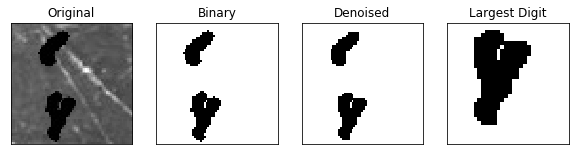

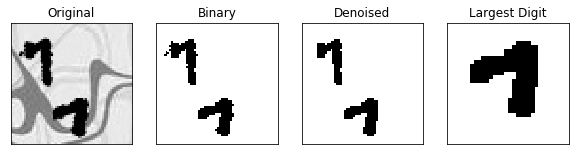

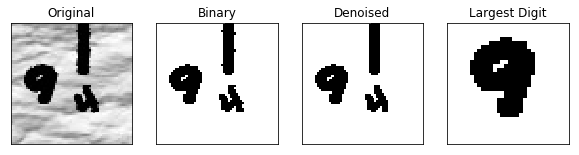

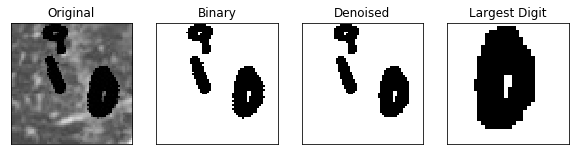

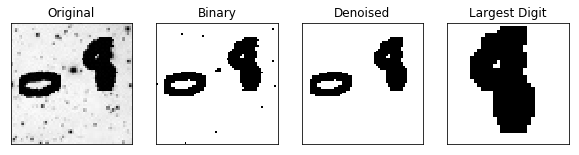

In [7]:
def plot_images(images, titles):
    cols = len(images)
    rows = len(images[0])
    
    print(cols, rows)
    for r in range(rows):
        for c in range(cols):
            plt.subplot(1,cols,c+1)
            plt.imshow(images[c][r],'gray')
            plt.title(titles[c])
            plt.xticks([]),plt.yticks([])
        
        plt.show()
        
titles = ['Original', 'Binary', 'Denoised', 'Largest Digit']
images = [imgs[:5], bin_imgs[:5], denoised_imgs[:5], largest_digits[:5]]
plot_images(images, titles)

#### Split the clean data

In [8]:
clean_X = []
for i in range(len(largest_digits)):
    clean_X.append(largest_digits[i].flatten())

clean_X = np.divide(255-np.array(clean_X),255)

X_train, X_test, y_train, y_test = train_test_split(clean_X, clean_y, test_size=0.3, random_state=SEED)

### 1. Linear Learners

In [9]:
%%time
# hyperparameter permutations
FOLDS = 3 
DUAL = [False] 
LOSSES = ['squared_hinge','hinge']
PENALTIES = ['l1','l2']
SOLVERS = ['lbfgs']

KFOLD = KFold(n_splits=FOLDS, random_state=SEED)

CPU times: user 16 µs, sys: 8 µs, total: 24 µs
Wall time: 26.7 µs


#### Base and dummy clf performances for reference

In [10]:
%%time
# dummy clf performance
random_clf = DummyClassifier(random_state=42)
result = cross_val_score(random_clf, X_train, y_train, cv=KFOLD, scoring='accuracy')
print('Random clf performance: {:.4f}'.format(result.mean()))

# Base performance (default HP)
result = cross_val_score(LinearSVC(), X_train, y_train, cv=KFOLD, scoring='accuracy')
print('LinearSVM base performance: {:.4f}'.format(result.mean()))

result = cross_val_score(LogisticRegression(), X_train, y_train, cv=KFOLD, scoring='accuracy')
print('LogReg base performance: {:.4f}'.format(result.mean()))

Random clf performance: 0.0984
LinearSVM base performance: 0.5946
LogReg base performance: 0.6057
CPU times: user 10min 16s, sys: 1.13 ms, total: 10min 16s
Wall time: 10min 21s


#### Perform Model Selection for LinearSM

In [11]:
%%time
parameters = {'C':np.linspace(0.0005,0.001, 10)}
svc = LinearSVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy')
clf.fit(X_train, y_train)
print('HyperParameters chosen by CV: {}'.format(clf.best_params_ ))
print('Testing Score: {:.4f}'.format(clf.score(X_test, y_test)))

HyperParameters chosen by CV: {'C': 0.0009444444444444445}
Testing Score: 0.6179
CPU times: user 1min 24s, sys: 2.8 s, total: 1min 27s
Wall time: 1min 27s


#### Perform Model Selection for LogisticRegression

In [12]:
%%time

parameters = {'C':np.linspace(0.005,0.02, 10),'solver':SOLVERS,'n_jobs':[8]}
logit = LogisticRegression()
clf = GridSearchCV(logit, parameters, scoring='accuracy')
clf.fit(X_train, y_train)
print('HyperParameters chosen by CV: {}'.format(clf.best_params_ ))
print('Testing Score: {:.4f}'.format(clf.score(X_test, y_test)))

HyperParameters chosen by CV: {'C': 0.006666666666666666, 'n_jobs': 8, 'solver': 'lbfgs'}
Testing Score: 0.6324
CPU times: user 2min, sys: 19.4 s, total: 2min 20s
Wall time: 1h 40min 53s
